# novozymes-enzyme-stability-prediction

# 前処理

In [51]:
import os
import sys
from datetime import datetime, timedelta, date

import pandas as pd
from time import sleep
from urllib import request
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from tqdm.notebook import tqdm

import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

import warnings # 実行に関係ない警告を無視
warnings.filterwarnings('ignore')

HOME_PATH = os.getcwd()
sys.path.append(HOME_PATH)

%matplotlib inline

## データ一覧

In [52]:
train = pd.read_csv(f'{HOME_PATH}/train.csv')
train_updates = pd.read_csv(f'{HOME_PATH}/train_updates_20220929.csv')
test = pd.read_csv(f'{HOME_PATH}/test.csv')

### train.csv

In [53]:
print(train.shape)
train.tail()

(31390, 5)


,seq_id,protein_sequence,pH,data_source,tm
31385,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,doi.org/10.1038/s41592-020-0801-4,51.8
31386,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,doi.org/10.1038/s41592-020-0801-4,37.2
31387,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,doi.org/10.1038/s41592-020-0801-4,64.6
31388,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.7
31389,31389,YYVPDEYWQSLEVAHKLTFGYGYLTWEWVQGIRSYVYPLLIAGLYK...,7.0,doi.org/10.1038/s41592-020-0801-4,37.6


### train_updates_20220929.csv

In [54]:
print(train_updates.shape)
train_updates.isnull().sum()

(2434, 5)


seq_id                 0
protein_sequence    2409
pH                  2409
data_source         2434
tm                  2409
dtype: int64

### test.csv

In [55]:
print(test.shape)
test.head()

(2413, 4)


,seq_id,protein_sequence,pH,data_source
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


### wildtype_structure_prediction_af2.pd

In [56]:
# pip install biopandas
from biopandas.pdb import PandasPdb

pdb_df =  PandasPdb().read_pdb(f'{HOME_PATH}/wildtype_structure_prediction_af2.pdb')
print(pdb_df.df.keys())
atom_df = pdb_df.df['ATOM']
hetatm_df = pdb_df.df['HETATM']
anisou_df = pdb_df.df['ANISOU']
others_df = pdb_df.df['OTHERS']

dict_keys(['ATOM', 'HETATM', 'ANISOU', 'OTHERS'])


In [57]:
atom_df

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,N,,VAL,,A,1,,...,34.064,-6.456,50.464,1.0,45.11,,,N,NaN,0
1,ATOM,2,,H,,VAL,,A,1,,...,33.576,-6.009,51.228,1.0,45.11,,,H,NaN,1
2,ATOM,3,,H2,,VAL,,A,1,,...,33.882,-7.449,50.477,1.0,45.11,,,H,NaN,2
3,ATOM,4,,H3,,VAL,,A,1,,...,35.060,-6.323,50.566,1.0,45.11,,,H,NaN,3
4,ATOM,5,,CA,,VAL,,A,1,,...,33.643,-5.877,49.162,1.0,45.11,,,C,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3312,ATOM,3313,,NZ,,LYS,,A,221,,...,4.616,13.323,-4.301,1.0,93.80,,,N,NaN,3312
3313,ATOM,3314,,HZ1,,LYS,,A,221,,...,5.270,12.565,-4.432,1.0,93.80,,,H,NaN,3313
3314,ATOM,3315,,HZ2,,LYS,,A,221,,...,4.585,13.517,-3.310,1.0,93.80,,,H,NaN,3314
3315,ATOM,3316,,HZ3,,LYS,,A,221,,...,4.965,14.143,-4.776,1.0,93.80,,,H,NaN,3315


## データの更新と結合

In [58]:
# 値が２つ以上ある行のみ残す, updateを使うためindexを揃える
train_updates = train_updates.dropna(thresh=2).set_index('seq_id')
train_updates.head()

,protein_sequence,pH,data_source,tm
seq_id,,,,
973,DTSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,7.0,NaN,48.4
986,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVTFQNRESVLPT...,7.0,NaN,48.4
988,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFANRESVLPT...,7.0,NaN,49.0
989,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFANRESVLPT...,5.5,NaN,55.6
1003,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESTLPT...,7.0,NaN,48.4


In [59]:
# 今後testとtrainデータは結合して処理する
df = pd.concat([train, test]).reset_index(drop=True)
print(df.shape)
df.head()

(33803, 5)


,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [60]:
# train_updatesで上書き
df.update(train_updates, overwrite=True)

# 消していいよね
df = df.drop(['seq_id', 'data_source'], axis=1)
df.head()

,protein_sequence,pH,tm
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5


## protein_sequence

In [61]:
# 配列の種類
print(len(train.protein_sequence.unique()))
df.protein_sequence.value_counts()

28981


MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSELDKAIGRNCNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRHCALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSIWYNQTPNRAKRVITTFRTGTWDAYKNL                                                                                                                                                                                                                                                                                                                                                                  14
MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLTVGKGVSATTAAPERAVTLTCAPGPSGTHPAAGSACADLAAVGGDLNALTRGEDVMCPMVYDPVLLTVNGVWQGKRVSYERVFSNECEMNAHGSSVFAF                                                                                                                                                                                                                                                                                                                                               

### アミノ酸の個数

In [62]:
# protein_sequence の配列要素数を特徴量として抽出
from collections import Counter

Chr_lis = [chr(i) for i in range(65, 65+26)] # アルファベットのリスト
for i in Chr_lis:
    df[i] = df['protein_sequence'].apply(lambda x: Counter(x)[i]) # Counter[i] でもok

# protein_sequence の長さを追加
df['len'] = df['protein_sequence'].apply(len)

In [63]:
df

,protein_sequence,pH,tm,A,B,C,D,E,F,G,...,R,S,T,U,V,W,X,Y,Z,len
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,45,0,1,13,30,13,38,...,25,11,14,0,37,4,0,3,0,341
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,28,0,0,10,52,6,18,...,30,14,12,0,13,3,0,3,0,286
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,50,0,9,27,32,21,65,...,31,33,30,0,30,3,0,16,0,497
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,20,0,5,19,29,12,16,...,10,16,19,0,14,3,0,4,0,265
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,86,0,14,78,78,32,84,...,63,148,120,0,124,16,0,47,0,1451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8.0,NaN,21,0,4,15,7,10,19,...,3,18,8,0,13,6,0,6,0,221
33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8.0,NaN,21,0,4,15,7,10,19,...,3,18,8,0,13,6,0,6,0,221
33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8.0,NaN,21,0,4,15,7,10,19,...,3,18,8,0,13,6,0,6,0,221
33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8.0,NaN,21,0,4,15,7,10,19,...,3,18,8,0,13,6,0,6,0,221


In [64]:
# 一個も含まれない列は消す
df = df.drop(['B', 'J', 'O', 'U', 'X', 'Z'], axis=1)

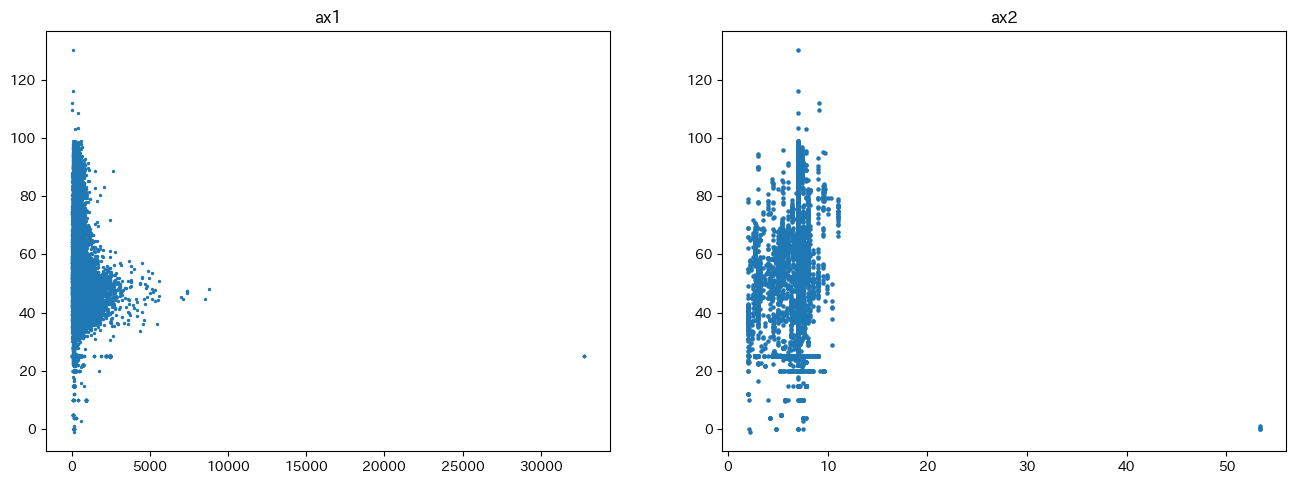

In [65]:
fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

# plt.subplots_adjust(wspace=0.5, hspace=0.5)

#ax2に散布図を表示
ax1.set_title('ax1')
c_1 = df.len
c_2 = df.tm
ax1.scatter(c_1, c_2, s=2)

#ax2に散布図を表示
ax2.set_title('ax2')
c_1 = df.pH
c_2 = df.tm
ax2.scatter(c_1, c_2, s=5)

plt.show()

In [66]:
# 外れ値は削除（全てtrainデータ内であることを確認済み）
len_over_30000 = df[df.len > 10000]
ph_over_15 = df.query('pH > 15')
print('配列の長さが30000以上の要素数: ', len(len_over_30000))
print('pHが15以上の要素数: ', len(ph_over_15))
df = df.drop(len_over_30000.index)
df = df.drop(ph_over_15.index)  # df = df.drop(df.query('pH > 20').index)

配列の長さが30000以上の要素数:  7
pHが15以上の要素数:  4


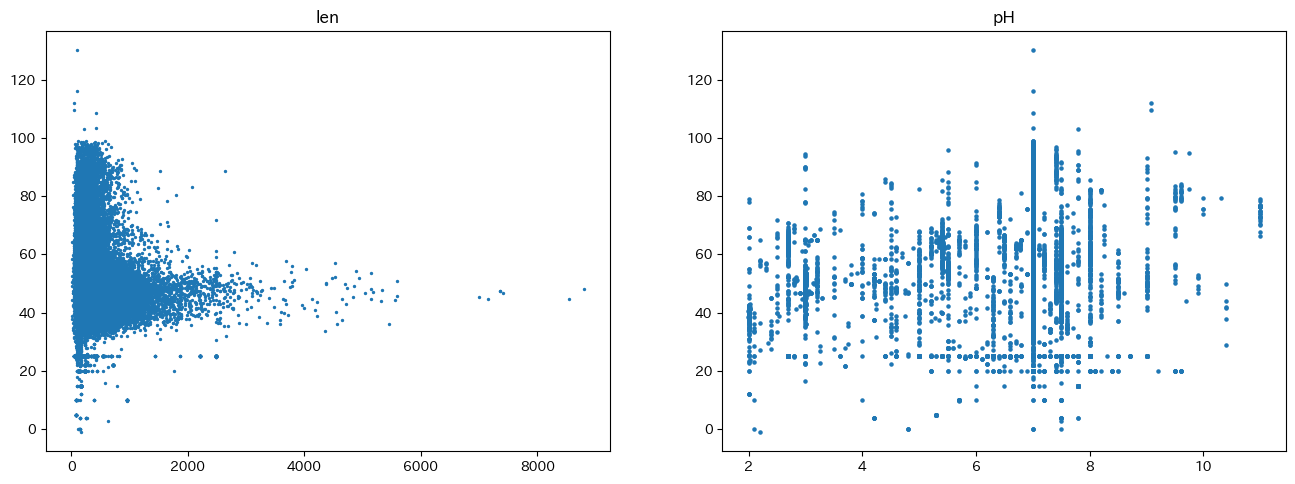

In [67]:
fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

# plt.subplots_adjust(wspace=0.5, hspace=0.5)

#ax2に散布図を表示
ax1.set_title('len')
c_1 = df.len
c_2 = df.tm
ax1.scatter(c_1, c_2, s=2)

#ax2に散布図を表示
ax2.set_title('pH')
c_1 = df.pH
c_2 = df.tm
ax2.scatter(c_1, c_2, s=5)

plt.show()

In [68]:
df

,protein_sequence,pH,tm,A,C,D,E,F,G,H,...,N,P,Q,R,S,T,V,W,Y,len
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,45,1,13,30,13,38,3,...,5,18,6,25,11,14,37,4,3,341
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,28,0,10,52,6,18,4,...,6,8,22,30,14,12,13,3,3,286
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,50,9,27,32,21,65,11,...,15,20,25,31,33,30,30,3,16,497
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,20,5,19,29,12,16,7,...,9,16,9,10,16,19,14,3,4,265
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,86,14,78,78,32,84,40,...,65,128,54,63,148,120,124,16,47,1451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8.0,NaN,21,4,15,7,10,19,0,...,19,17,13,3,18,8,13,6,6,221
33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8.0,NaN,21,4,15,7,10,19,0,...,19,17,13,3,18,8,13,6,6,221
33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8.0,NaN,21,4,15,7,10,19,0,...,20,17,13,3,18,8,13,6,6,221
33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8.0,NaN,21,4,15,7,10,19,0,...,19,18,13,3,18,8,13,6,6,221


### 分子量

In [69]:
# 各アミノ酸の分子量を合計する（結合部分は考えない）

def calcu_weight(series):

    acid_weight = {'A':89.1, 'C':121.6, 'D':133.1, 'E':147.13, 'F':165.2, 'G':75.1, 'H':155.2, 'I':131.2,
                'K':146.2, 'L':131.2, 'M':149.2, 'N':132.1, 'P':115.1, 'Q':146.2, 'R':174.2, 'S':105.1, 
                'T':119.1, 'V':117.2, 'W':204.2, 'Y':181.2} # 今回Uはなかった
    weight = 0
    
    for key in acid_weight:
        weight += series[key] * acid_weight[key]
    
    return weight


# 分子量の列を追加
# df['weight'] = df.apply(lambda x: calcu_weight(x), axis=1)

In [70]:
df

,protein_sequence,pH,tm,A,C,D,E,F,G,H,...,N,P,Q,R,S,T,V,W,Y,len
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,45,1,13,30,13,38,3,...,5,18,6,25,11,14,37,4,3,341
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,28,0,10,52,6,18,4,...,6,8,22,30,14,12,13,3,3,286
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,50,9,27,32,21,65,11,...,15,20,25,31,33,30,30,3,16,497
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,20,5,19,29,12,16,7,...,9,16,9,10,16,19,14,3,4,265
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,86,14,78,78,32,84,40,...,65,128,54,63,148,120,124,16,47,1451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8.0,NaN,21,4,15,7,10,19,0,...,19,17,13,3,18,8,13,6,6,221
33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8.0,NaN,21,4,15,7,10,19,0,...,19,17,13,3,18,8,13,6,6,221
33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8.0,NaN,21,4,15,7,10,19,0,...,20,17,13,3,18,8,13,6,6,221
33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8.0,NaN,21,4,15,7,10,19,0,...,19,18,13,3,18,8,13,6,6,221


## 欠損値の処理

In [71]:
# 欠損値の確認
df.isnull().sum()[df.isnull().sum() > 0]

pH     286
tm    2413
dtype: int64

In [72]:
# pHはほぼ７なのでそれで補完
print(df.pH.value_counts())
df = df.fillna({'pH': 7})
df.isnull().sum()[df.isnull().sum() > 0]

7.00     26480
8.00      2915
7.50       576
3.00       288
2.70       276
         ...  
8.30         1
2.84         1
2.86         1
2.34         1
10.30        1
Name: pH, Length: 109, dtype: int64


tm    2413
dtype: int64

# モデリング

In [73]:
df

,protein_sequence,pH,tm,A,C,D,E,F,G,H,...,N,P,Q,R,S,T,V,W,Y,len
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,45,1,13,30,13,38,3,...,5,18,6,25,11,14,37,4,3,341
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,28,0,10,52,6,18,4,...,6,8,22,30,14,12,13,3,3,286
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,50,9,27,32,21,65,11,...,15,20,25,31,33,30,30,3,16,497
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,20,5,19,29,12,16,7,...,9,16,9,10,16,19,14,3,4,265
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,86,14,78,78,32,84,40,...,65,128,54,63,148,120,124,16,47,1451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8.0,NaN,21,4,15,7,10,19,0,...,19,17,13,3,18,8,13,6,6,221
33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8.0,NaN,21,4,15,7,10,19,0,...,19,17,13,3,18,8,13,6,6,221
33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8.0,NaN,21,4,15,7,10,19,0,...,20,17,13,3,18,8,13,6,6,221
33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8.0,NaN,21,4,15,7,10,19,0,...,19,18,13,3,18,8,13,6,6,221


In [74]:
# 説明変数、目的変数の設定
from sklearn.model_selection import train_test_split

# index番号31389までがtrainデータ 外れ値消したからdf.iloc[len(train):]とかはダメ
X = df[df.index <= 31389].drop(['tm', 'protein_sequence'], axis=1).values
y = df[df.index <= 31389].tm.values * 10 # lgbmが少数を扱えないので
X_test = df[df.index > 31389].drop(['tm', 'protein_sequence'], axis=1).values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

## チューニング

In [75]:
# def objective(trial):
#     import optuna.integration.lightgbm as lgb
#     from sklearn.metrics import mean_squared_error # モデル評価用(平均二乗誤差)
#     from sklearn.metrics import r2_score # モデル評価用(決定係数)
    
#     X_train, X_valid, y_train, y_valid, test = get_data()    
#     X_test = test.copy()
    
#     params_dist = {
#         'boosting'          : 'gbdt',
#         'metric'            : 'auc',
#         'objective'         : 'regression',
#         'learning_rate'     : 0.05,
#         'lambda_l1'         : trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
#         'lambda_l2'         : trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
#         'num_leaves'        : trial.suggest_int('num_leaves', 2, 512),
#         'feature_fraction'  : trial.suggest_uniform('feature_fraction', 0.4, 1.0),
#         'bagging_fraction'  : trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
#         'bagging_freq'      : trial.suggest_int('bagging_freq', 0, 10),
#         'min_child_samples' : trial.suggest_int('min_child_samples', 5, 100),
#         'seed'              : 42,
#         'verbosity'         : -1,
#     }
    
#     lgb_train = lgb.Dataset(X_train, y_train)
#     lgb_eval  = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

#     evaluation_results = {}
#     model = lgb.train(params_dist,
#                       lgb_train,
#                       valid_sets=(lgb_train, lgb_eval),
#                       valid_names=["Train", "Test"],
#                       evals_result=evaluation_results,
#                       num_boost_round=100000,
#                       early_stopping_rounds=100,
#                       verbose_eval=-1,
#                       )
    
#     y_prob_val = model.predict(X_valid, num_iteration=model.best_iteration)
#     y_pred_val = np.round(y_prob_val)

#     # rmse : 平均二乗誤差の平方根
#     mse = mean_squared_error(y_valid, y_pred_val) # MSE(平均二乗誤差)の算出
#     score = np.sqrt(mse) # RSME = √MSEの算出
#     # rmse : 平均二乗誤差の平方根

#     return score 

In [76]:
# objective(trial)

## LGBM Python API

In [77]:
## Python API ##
import lightgbm as lgb
from lightgbm import Dataset

# データセットを生成する
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train) 

# LightGBMのハイパーパラメータ
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression', # 目的 : 回帰  
        'metric': {'rmse'}, # 評価指標 : rsme(平均二乗誤差の平方根) 
}

# 上記のパラメータでモデルを学習する
model = lgb.train(params,
                  train_set=lgb_train, # トレーニングデータの指定
                  valid_sets=lgb_eval, # 検証データの指定
                  )

# データの予測
train_pred_pyapi = model.predict(X_train)
valid_pred_pyapi = model.predict(X_valid)
test_pred_pyapi = model.predict(X_test)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 21965, number of used features: 22
[LightGBM] [Info] Start training from score 491.471068
[1]	valid_0's rmse: 135.545
[2]	valid_0's rmse: 131.597
[3]	valid_0's rmse: 128.284
[4]	valid_0's rmse: 125.073
[5]	valid_0's rmse: 122.416
[6]	valid_0's rmse: 119.998
[7]	valid_0's rmse: 117.891
[8]	valid_0's rmse: 115.874
[9]	valid_0's rmse: 114.289
[10]	valid_0's rmse: 112.753
[11]	valid_0's rmse: 111.32
[12]	valid_0's rmse: 110.03
[13]	valid_0's rmse: 108.883
[14]	valid_0's rmse: 107.781
[15]	valid_0's rmse: 106.843
[16]	valid_0's rmse: 105.9
[17]	valid_0's rmse: 105.14
[18]	valid_0's rmse: 104.313
[19]	valid_0's rmse: 103.603
[20]	valid_0's rmse: 102.952
[21]	valid_0's rmse: 102.369
[22]	valid_0's rmse: 101.848
[23]	valid_0's rmse: 101.35
[

In [78]:
test_pred_pyapi

array([425.30633065, 425.30633065, 425.30633065, ..., 425.30633065,
       432.85839242, 425.30633065])

,tm,tm_pred
0,508.0,470.529536
1,424.0,448.142378
2,539.0,567.960676
3,527.0,499.892993
4,494.0,478.508308
...,...,...
9409,313.0,400.697257
9410,464.0,451.208491
9411,573.0,438.363371
9412,492.0,448.553407


Text(0.5, 1.0, 'y vs valid_pred_api')

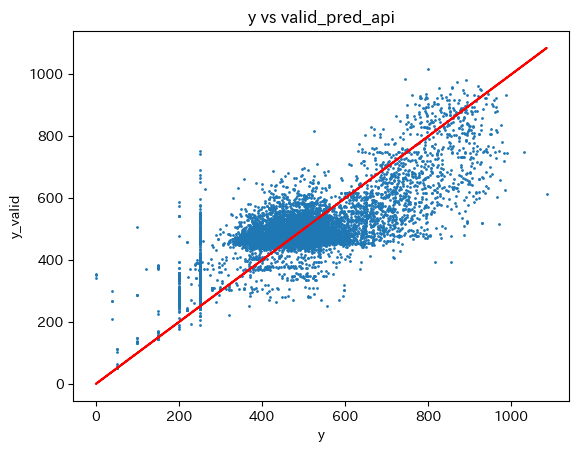

In [79]:
# 真値と予測値の表示
df_pred = pd.DataFrame({'tm':y_valid,'tm_pred':valid_pred_pyapi})
display(df_pred)

# 散布図を描画(真値 vs 予測値)
plt.plot(y_valid, y_valid, color = 'red', label = 'x=y') # 直線y = x (真値と予測値が同じ場合は直線状に点がプロットされる)
plt.scatter(y_valid, valid_pred_pyapi, s=1) # 散布図のプロット
plt.xlabel('y') # x軸ラベル
plt.ylabel('y_valid') # y軸ラベル
plt.title('y vs valid_pred_api') # グラフタイトル


# https://mathmatical22.xyz/2020/04/09/

## LGBM scikit-learn API

In [80]:
## scikit-learn API ##
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=42)
lgb.fit(X_train, y_train)

train_pred_skl = lgb.predict(X_train)
valid_pred_skl = lgb.predict(X_valid)

test_pred_skl = lgb.predict(X_test)

,tm,tm_pred
0,508.0,474.0
1,424.0,474.0
2,539.0,474.0
3,527.0,474.0
4,494.0,474.0
...,...,...
9409,313.0,474.0
9410,464.0,474.0
9411,573.0,504.0
9412,492.0,474.0


Text(0.5, 1.0, 'y vs valid_pred_skl')

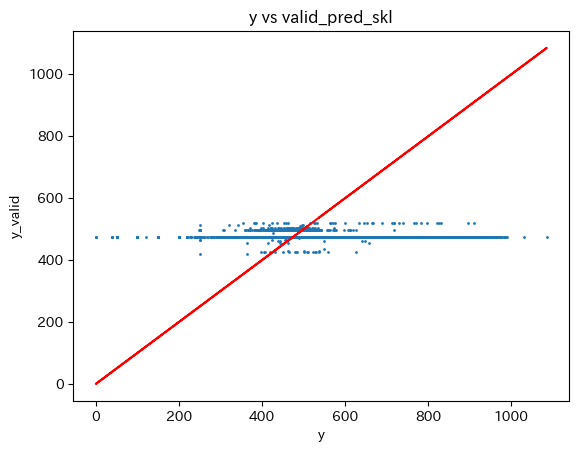

In [81]:
# 真値と予測値の表示
df_pred = pd.DataFrame({'tm':y_valid,'tm_pred':valid_pred_skl})
display(df_pred)

# 散布図を描画(真値 vs 予測値)
plt.plot(y_valid, y_valid, color = 'red', label = 'x=y') # 直線y = x (真値と予測値が同じ場合は直線状に点がプロットされる)
plt.scatter(y_valid, valid_pred_skl, s=1) # 散布図のプロット
plt.xlabel('y') # x軸ラベル
plt.ylabel('y_valid') # y軸ラベル
plt.title('y vs valid_pred_skl') # グラフタイトル

In [82]:
# モデル評価
from sklearn.metrics import mean_squared_error # モデル評価用(平均二乗誤差)
from sklearn.metrics import r2_score # モデル評価用(決定係数)

# rmse : 平均二乗誤差の平方根
mse = mean_squared_error(y_valid, valid_pred_skl) # MSE(平均二乗誤差)の算出
rmse = np.sqrt(mse) # RSME = √MSEの算出
print('RMSE :',rmse)

# r2 : 決定係数
r2 = r2_score(y_valid, valid_pred_skl)
print('R2 :',r2)

RMSE : 141.34101287504583
R2 : -0.020419243282255417


## XGboost

In [85]:
# !pip install xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

xgb_reg = xgb.XGBRegressor()

params=[{'max_depth':[3,4,5,6],
        'n_estimators':[100,300,500]
       }]

scorer = make_scorer(mean_squared_error)

grid_xgb_reg=GridSearchCV(xgb_reg,
                          param_grid=params,
                          scoring=scorer,
                          cv=5,
                          n_jobs=-1)

grid_xgb_reg.fit(X_train, y_train)

train_pred_xg = grid_xgb_reg.predict(X_train)
valid_pred_xg = grid_xgb_reg.predict(X_valid)
test_pred_xg = grid_xgb_reg.predict(X_test)

# 最良スコアとなるパラメータ値を出力
print(grid_xgb_reg.best_params_)

{'max_depth': 3, 'n_estimators': 100}


,tm,tm_pred
0,508.0,480.393707
1,424.0,460.571625
2,539.0,536.348572
3,527.0,535.034058
4,494.0,485.499451
...,...,...
9409,313.0,373.674683
9410,464.0,454.979218
9411,573.0,468.633789
9412,492.0,466.452026


Text(0.5, 1.0, 'y vs valid_pred_xg')

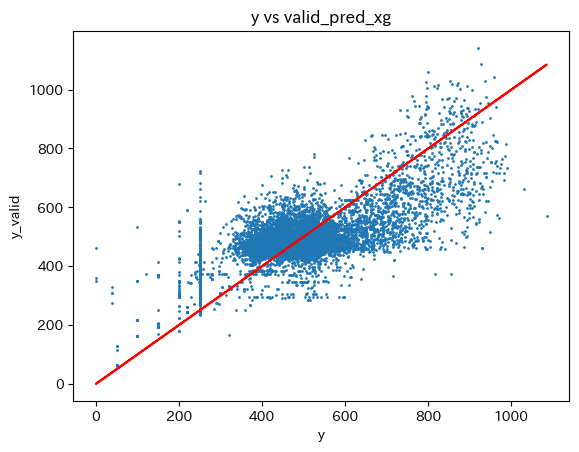

In [86]:
# 真値と予測値の表示
df_pred = pd.DataFrame({'tm':y_valid,'tm_pred':valid_pred_xg})
display(df_pred)

# 散布図を描画(真値 vs 予測値)
plt.plot(y_valid, y_valid, color = 'red', label = 'x=y') # 直線y = x (真値と予測値が同じ場合は直線状に点がプロットされる)
plt.scatter(y_valid, valid_pred_xg, s=1) # 散布図のプロット
plt.xlabel('y') # x軸ラベル
plt.ylabel('y_valid') # y軸ラベル
plt.title('y vs valid_pred_xg') # グラフタイトル

## アンサンブル

,tm,tm_pred
0,508.0,475.461622
1,424.0,454.357001
2,539.0,552.154624
3,527.0,517.463525
4,494.0,482.003879
...,...,...
9409,313.0,387.185970
9410,464.0,453.093854
9411,573.0,453.498580
9412,492.0,457.502717


Text(0.5, 1.0, 'y vs valid_pred_ens')

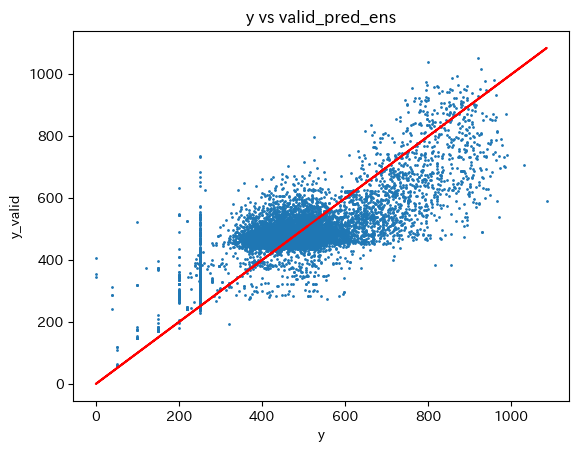

In [87]:
# xgboostとLGBN(pyapi)のアンサンブル
valid_pred_ens = valid_pred_xg*0.5 + valid_pred_pyapi*0.5
test_pred_ens = test_pred_xg*0.5 + test_pred_pyapi*0.5

# 真値と予測値の表示
df_pred = pd.DataFrame({'tm':y_valid,'tm_pred':valid_pred_ens})
display(df_pred)

# 散布図を描画(真値 vs 予測値)
plt.plot(y_valid, y_valid, color = 'red', label = 'x=y') # 直線y = x (真値と予測値が同じ場合は直線状に点がプロットされる)
plt.scatter(y_valid, valid_pred_ens, s=1) # 散布図のプロット
plt.xlabel('y') # x軸ラベル
plt.ylabel('y_valid') # y軸ラベル
plt.title('y vs valid_pred_ens') # グラフタイトル

# 提出

In [88]:
# テストデータに対する予測値の作成

# pred = test_pred_pyapi/10
# pred = test_pred_skl/10
# pred = test_pred_xg/10
pred = test_pred_ens/10

# 予測結果を提出用のフォーマットに格納
submission = pd.read_csv(f'{HOME_PATH}/sample_submission.csv')
submission['tm'] = pred
print(submission)

# 提出用のcsvファイルを作成
submission.to_csv(f'{HOME_PATH}/submission/submission5.csv', index=False)

      seq_id         tm
0      31390  41.096745
1      31391  39.122250
2      31392  39.122250
3      31393  41.170293
4      31394  38.269534
...      ...        ...
2408   33798  39.122250
2409   33799  42.047304
2410   33800  39.122250
2411   33801  42.037709
2412   33802  37.998765

[2413 rows x 2 columns]


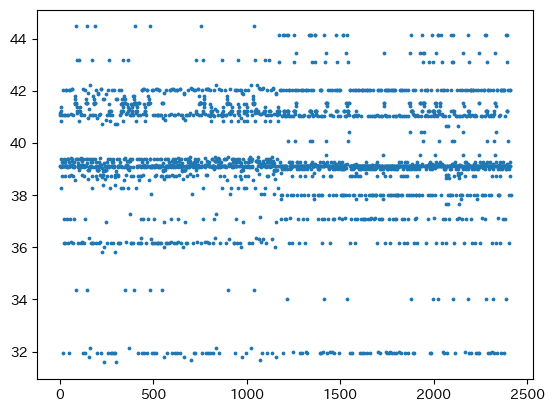

In [90]:
plt.scatter(range(len(test_pred_pyapi)), test_pred_ens/10, s=3)